# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План работы:


    - Загрузка данных и библиотек;
    - Первичный осмотр данных;
    - Предобработка данных;
    - Исследовательский анализ данных;
    - Подготовка данных для обучения моделей;
    - Обучение моделей;
    - Сравнение показателей точности и быстродействия моделей;
    - Общий вывод по проекту.
    - Проверка работоспособности кода и комментариев (контрольная проверка перед отправкой на ревью).

## Загрузка библиотек и осмотр данных

In [1]:
! pip install catboost 

In [2]:
! pip install optuna 

In [3]:
! pip install fastai

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import catboost as cb
from catboost import CatBoostRegressor
from fastai.tabular.all import *
import lightgbm as lgbm

In [5]:
RANDOM_STATE = 42


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Собираем все импорты в верхней части, чтобы легче было ориентироваться и добавлять новые по необходимости. 

<div class="alert alert-warning">


Совет:

    

   

- есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html). Есть что поправить 



In [6]:
sns.set(rc={"figure.figsize":(15, 9)}) #немного красоты графикам
sns.set_style("darkgrid")

In [7]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except (FileNotFoundError, OSError) as e:
    try: # здесь нужно прописать путь к дф на стационарном компьютере
        df = pd.read_csv("C://Users/rdl_b/OneDrive/Рабочий стол/python/Yandex Practicum/Загрузка проектов/Проект 10/autos.csv")
    except (FileNotFoundError, OSError):
        print("Ошибка: не удалось загрузить данные")
else:
    print("Данные успешно загружены")

Данные успешно загружены


In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [11]:
print('Количество пропусков в столбцах:')
df.isna().sum().to_frame()

Количество пропусков в столбцах:


,0
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895


In [12]:
print('количество дубликатов:')
df.duplicated().sum()

количество дубликатов:


4

Вывод по загрузке библиотек и осмотру данных:

Загружены и импортирвоаны библиотеки которые понадобятся для выполнения данного проекта. Загружены ДФ, который вмещает свыше 352 тысяч строк. В некоторых столбцах содержится большое количество пропусков - их придется как-то обработать на этапе подготовки данных. Также найдены 4 дублирующих строки - их мы удалим. также приведем строки к snake_case и некоторым колонкам присвоим формат Datetime.
Несмотря на то, что в шаблоне проекта нет главы предобработка, мы всё-таки её проведем, тем более, в задании указано заполнить пропуски и удалить дубликаты и обработать аномалии. 
Я понимаю, что в целом так делать не стоит, но конкретно в этом проекте, думаю можно совместить шаг предобработки и ИАД.

## Предобработка данных и ИАД

### Первоначальная обработка и отсеивание данных

In [13]:
#Приведем к snake_case
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

In [14]:
df = df.drop_duplicates()
print('Количество дубликатов после обработки:', df.duplicated().sum())

Количество дубликатов после обработки: 0


Чтобы не выполнять лишнюю работу по ИАД и предобработке отсеим сразу те признаки, которые не влияют на стоимость автомобиля и следовательно не будут задействованы в исследовании.

Анализ признаков
Признаки, которые не помогут в определении стоимости:

    1) date_crawled - Дата скачивания анкеты не может влиять на стоимость автомобиля.
    2) month_of_registration - Порядковый номер месяца регистрации автомобиля, достаточно года.
    3) date_of_creation - точная дата публикации - непонятно как обрабатывать этот признак для обучения.
    Оставим только год публикации, так как стоимость может меняться год от года, как минимум под влиянием инфляции.
    4) number_of_pictures - судя по описанию данных, столбец не заполнен, во всех строках стоят нули.
    5) last_seen - Дата последней активности пользователя, думаю тоже лишнее.
    6) postal_code - Индекс места создания анкеты. Очень спорная колонка, но я всё-таки придерживаюсь мнения, что она лишняя. Конечно, населенный пункт имеет некоторое влияние на ценообразование, но здесь продают авто, а не недвижимость, влияние скорее всего минимальное. Кроме того, если бы данные были прописаны строками (к примеру город или населенный пункт) тогда, да, можно было бы оставить эту колонку. В данном случае значения индекса приведены числом, что скорее всего приведет к переобучению модели.

In [15]:
df_study = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'last_seen'], axis=1)

In [16]:
display(df_study)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes,2694
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


Эти столбцы и будем далее рассматривать и обрабатыват в них аномалии и пропуски.

### ИАД и обработка пропусков и аномалий.

#### price

In [17]:
df_study.price.describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

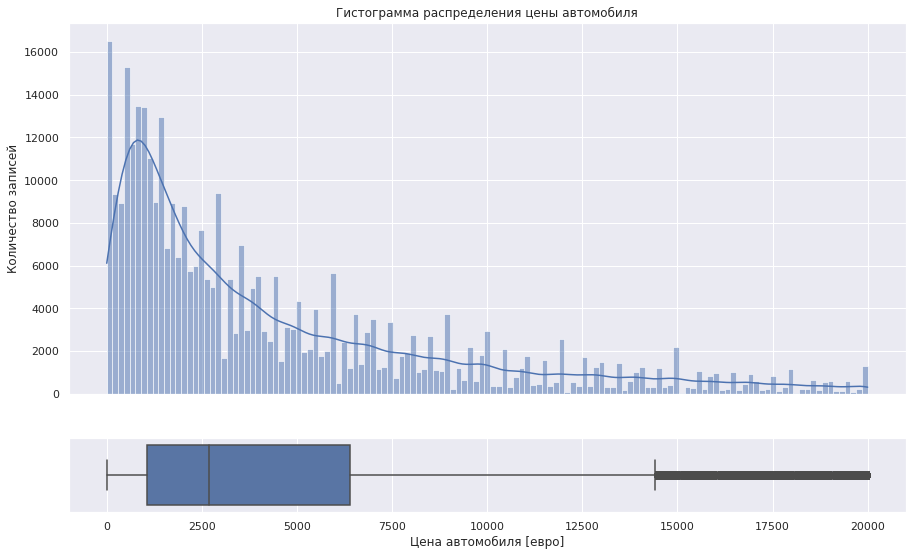

In [18]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df_study, x='price', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_study, x='price', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения цены автомобиля',
         ylabel='Количество записей')
box.set(xlabel='Цена автомобиля [евро]');

Из гистограммы и боксплота видно, что имеется большое количество записей с нулевой или очень низкой ценой. Это автомобили в очень плохом состоянии, которые сдают в утиль или ошибки? Также виден длинный "хвост" гистограммы с ценами, "улетающими в небо". Возможно, это автомобили премиум-класса или тоже опечатки (лишние ноли к примеру).
Чтобы наша модель была более предсказуемой сформируем новую выборку, в которой отфильтруем 1 процент записей с самыми низкими ценами и 1 процент записей с самыми высокими ценами.

In [19]:
low = df_study['price'].quantile(.01)
high = df_study['price'].quantile(.99)

In [20]:
df_study = df_study[(df_study['price'] > low) & (df_study['price'] < high)].copy()

Еще раз посмотрим на распределение:

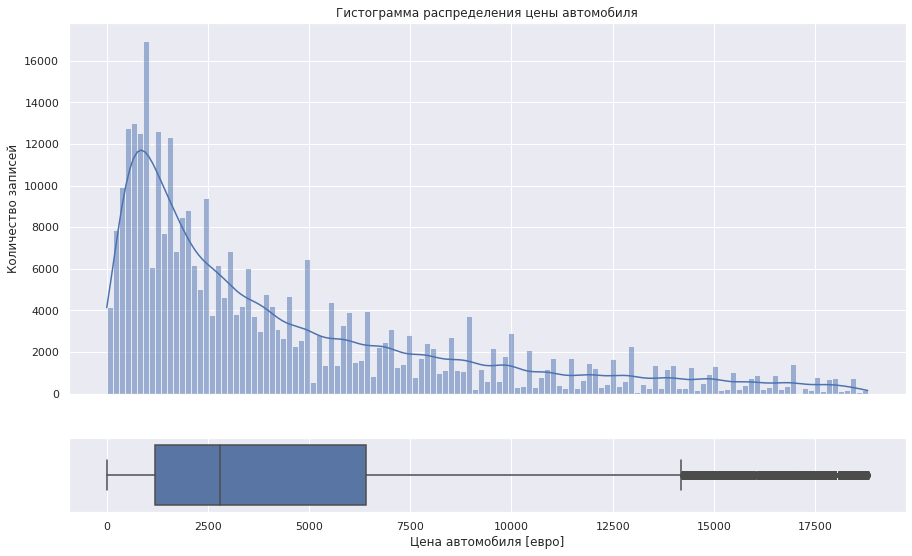

In [21]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df_study, x='price', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_study, x='price', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения цены автомобиля',
         ylabel='Количество записей')
box.set(xlabel='Цена автомобиля [евро]');

Хорошо, целевые данные немного подчистили.

#### vehicle_type

In [22]:
df_study.vehicle_type\
.value_counts(normalize=True, dropna=False)\
.sort_values(ascending=False).to_frame()

,vehicle_type
sedan,0.260131
small,0.229164
wagon,0.185513
NaN,0.098969
bus,0.082330
convertible,0.056962
coupe,0.044657
suv,0.033246
other,0.009028


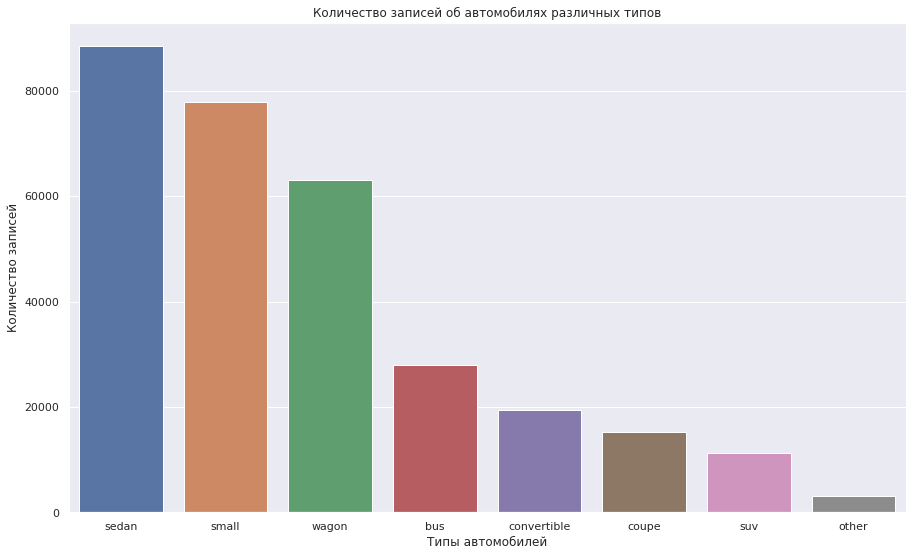

In [23]:
t = df_study.vehicle_type.value_counts(dropna=False)
sns.barplot(x=t.index, y=t).set(
    title='Количество записей об автомобилях различных типов',
    xlabel='Типы автомобилей',
    ylabel='Количество записей'
);

Согласно первичному осмотру данных в этой колонке наблюдалось большое количество пропусков. Просто удалить их будет "чувствительно" для анализа. Поэтому я вижу несколько путей решения проблемы.
- заполнить все пропуски значением "other";
- заполнить все пропуски значением "unknown";
- попробовать заполнить значения самым частым значением кузова исходя из марки автомобиля. Данный вариант, вероятно, был бы самым точным и предпочтительным. Но, исходя из того, что спринт короткий, в целях экономии времени, обойдемся вторым вариантом.

In [24]:
df_study['vehicle_type'] = df_study['vehicle_type'].fillna('unknown')

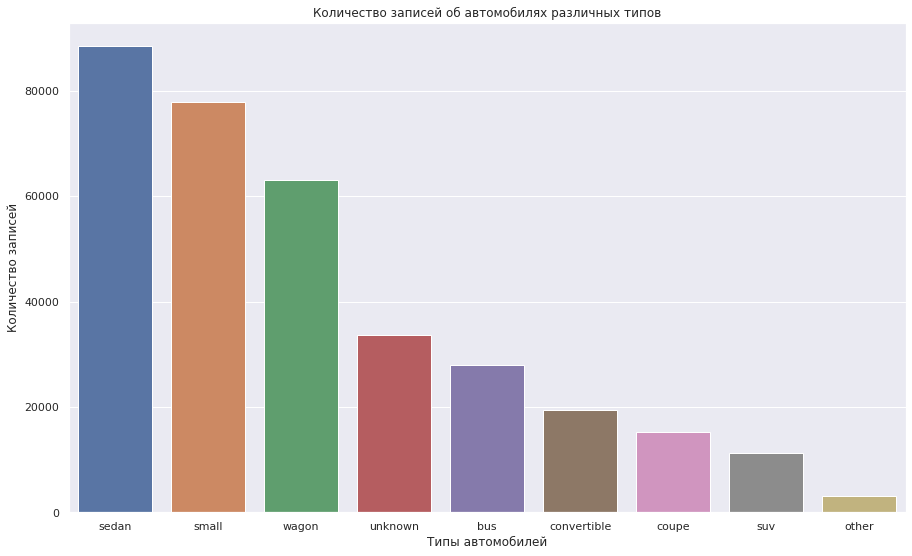

In [25]:
t = df_study.vehicle_type.value_counts(dropna=False)
sns.barplot(x=t.index, y=t).set(
    title='Количество записей об автомобилях различных типов',
    xlabel='Типы автомобилей',
    ylabel='Количество записей'
);

Категория получилась объемной, чтож пока пусть будет так.

#### registration_year

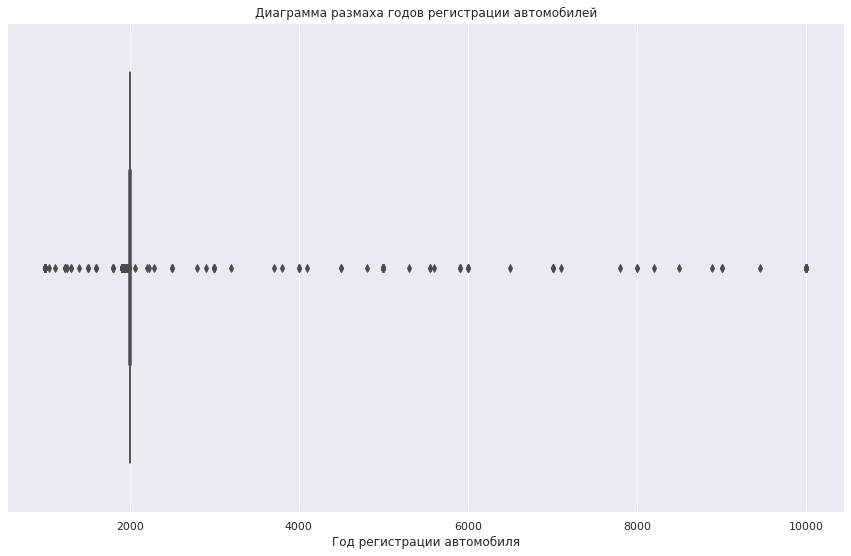

In [26]:
sns.boxplot(data=df_study, x='registration_year', orient='h')\
.set(title='Диаграмма размаха годов регистрации автомобилей',
    xlabel='Год регистрации автомобиля');

Боксплот получился странным, но информативным. Данные по году регистрации уходят как делеко в прошлое так и в далекое будущее.
Думаю стоит отсеять данные следующим образом. Прошлое мы отсечем 1885 годом - дата первого автомобиля. Будущее отсечем датой выгрузки базы - 2016.

In [27]:
df_study = df_study[df_study.registration_year <= 2016].copy()
df_study = df_study[df_study.registration_year > 1885].copy()

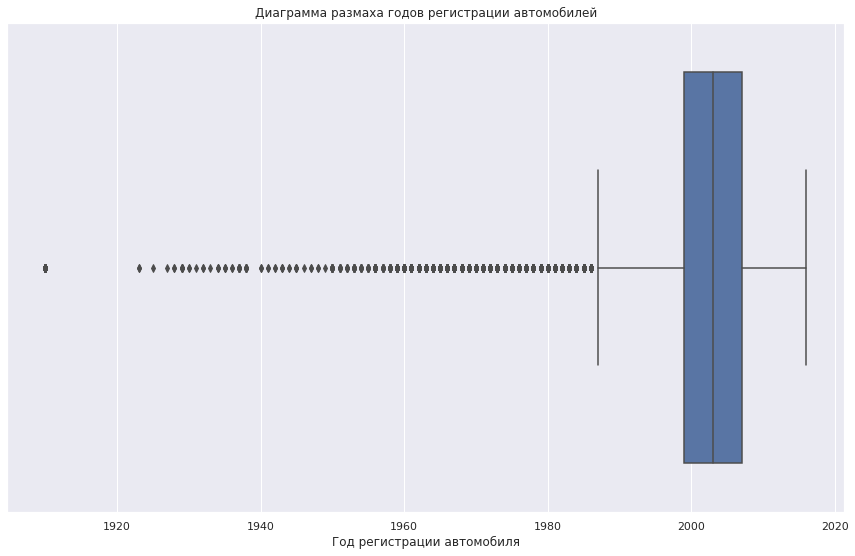

In [28]:
sns.boxplot(data=df_study, x='registration_year', orient='h')\
.set(title='Диаграмма размаха годов регистрации автомобилей',
    xlabel='Год регистрации автомобиля');

Ну вот, боксплот немного расслабился. Но меня все равно он немного смущает. Много выбросов, а заказчику важна точность определения рыночной стоимости. Поэтому, считаю, что все-таки значения регистрации ранее 1980 стоит убрать. Будут вносить неточности в модель.

In [29]:
df_study = df_study[df_study.registration_year > 1980].copy()

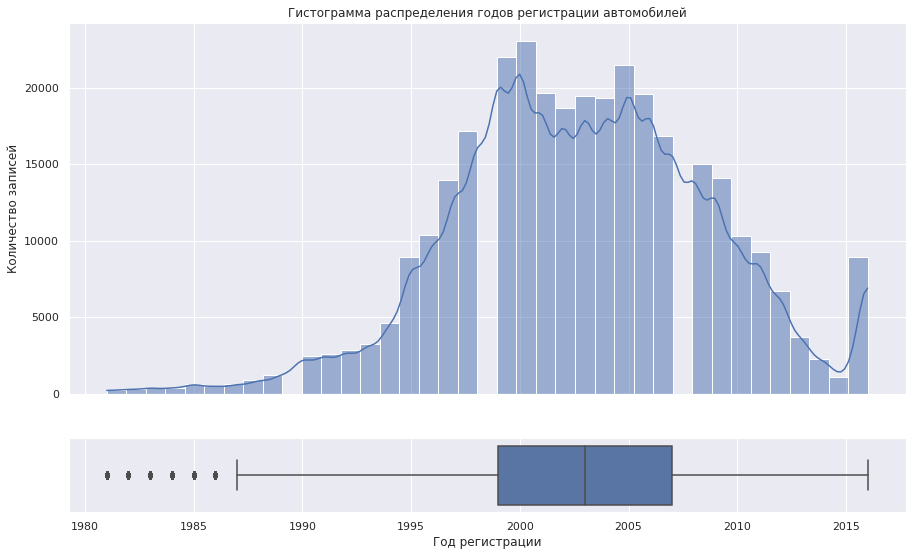

In [30]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = \
sns.histplot(data=df_study, x='registration_year', 
             kde=True, ax=axs_hist, bins=39)
box = sns.boxplot(data=df_study, x='registration_year', 
                  orient='h', ax=axs_box)
box.set(xlabel='Год регистрации')
hist.set(title='Гистограмма распределения годов регистрации автомобилей',
         ylabel='Количество записей');

Теперь всё выглядит более-менее.

#### gearbox

In [31]:
df_study.gearbox.value_counts(normalize=True, dropna=False)

manual    0.766506
auto      0.187544
NaN       0.045950
Name: gearbox, dtype: float64

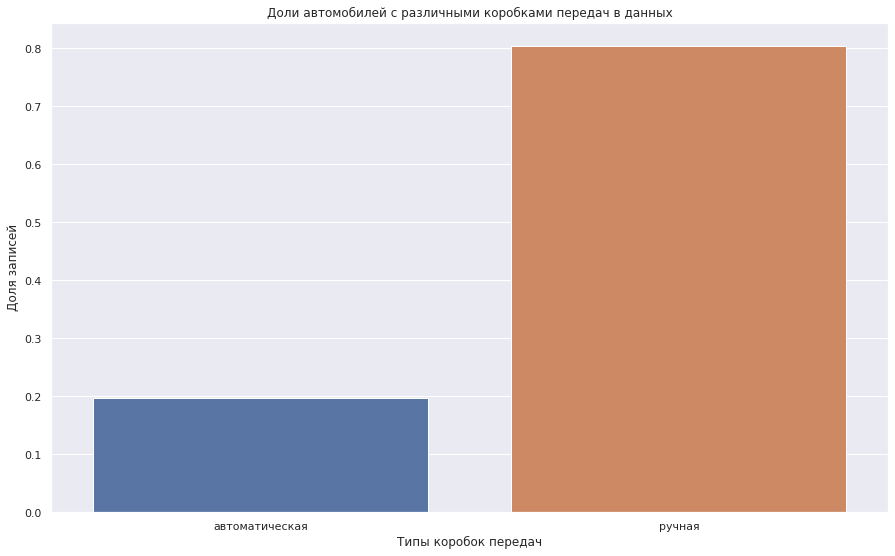

In [32]:
t = df_study.gearbox.value_counts(normalize=True)
ax = sns.barplot(data=t, y=t, x=t.index)
ax.set_xticklabels(['автоматическая', 'ручная'])
ax.set(xlabel='Типы коробок передач', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными коробками передач в данных');

Есть пропуски в графе коробка передач, заполним их ручной, как самым частым значением.

In [33]:
df_study['gearbox'] = df_study['gearbox'].fillna(value='manual')

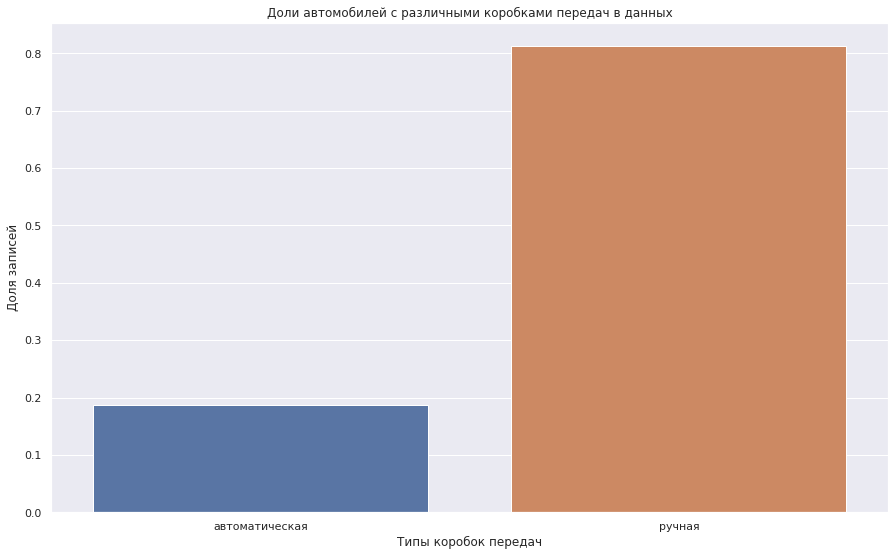

In [34]:
t = df_study.gearbox.value_counts(normalize=True)
ax = sns.barplot(data=t, y=t, x=t.index)
ax.set_xticklabels(['автоматическая', 'ручная'])
ax.set(xlabel='Типы коробок передач', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными коробками передач в данных');

#### power

In [35]:
df_study.power.describe().to_frame()

,power
count,322783.000000
mean,111.473727
std,184.069181
min,0.000000
25%,71.000000
50%,105.000000
75%,143.000000
max,20000.000000


Мощность серийных автомобилей находится в диапазоне ≈ 3-1600 л.с., судя по статьям в интернете. Отбросим явные аномальные значения:

In [36]:
df_study = df_study[df_study.power < 1600].copy()
df_study[df_study.power >= 3].copy()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,2016,auto,150,159,150000,NaN,alfa_romeo,no,51371
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,96465
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


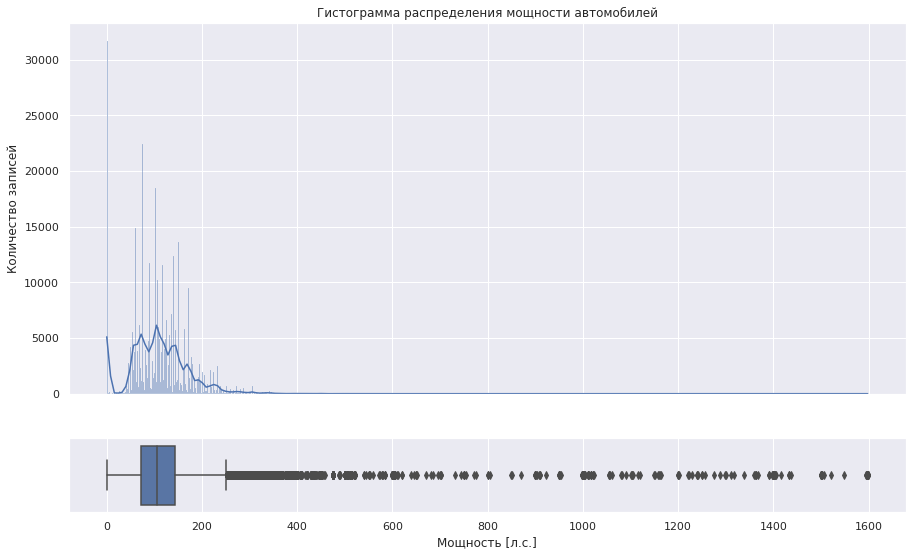

In [37]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = \
sns.histplot(data=df_study, x='power', 
             kde=True, ax=axs_hist)
box = sns.boxplot(data=df_study, x='power', orient='h', ax=axs_box)
box.set(xlabel='Мощность [л.с.]')
hist.set(title='Гистограмма распределения мощности автомобилей',
         ylabel='Количество записей');

Всё-таки, несмотря на то, что очень мощные автомобили существуют, вряд ли их будут оценивать через приложение - это ведь эксклюзив. Думаю, в рамках работы можно отбросить авто с мощностью выше 500 сил. Это скорее редкость, ведь среднее значение находится в районе 100-120 лошадей.

In [38]:
df_study = df_study[df_study.power < 500].copy()

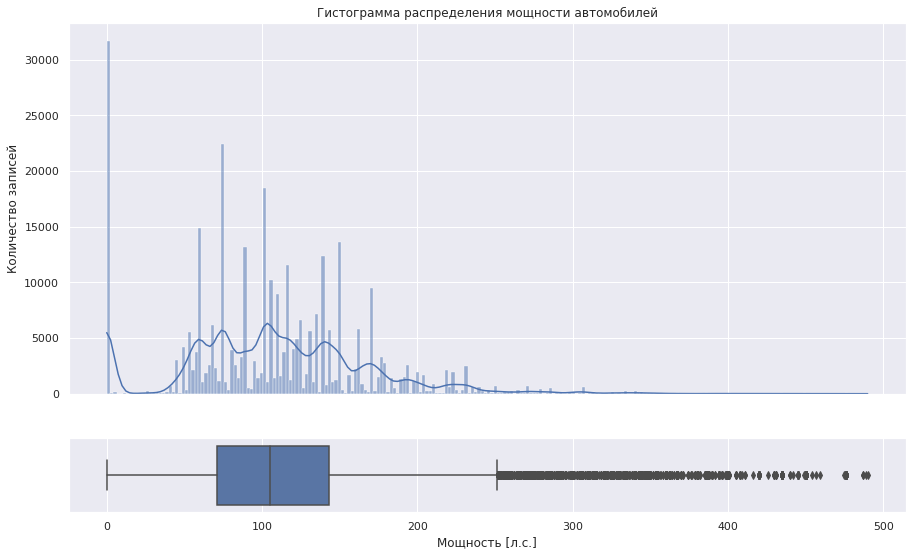

In [39]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = \
sns.histplot(data=df_study, x='power', 
             kde=True, ax=axs_hist)
box = sns.boxplot(data=df_study, x='power', orient='h', ax=axs_box)
box.set(xlabel='Мощность [л.с.]')
hist.set(title='Гистограмма распределения мощности автомобилей',
         ylabel='Количество записей');

Большой процент авто с мощностью ниже 10 л.с. Посмотрим, что там за автомобили.

In [40]:
display(df_study[df_study.power < 10])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,NaN,70435
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no,44145
37,1500,unknown,2016,manual,0,kangoo,150000,gasoline,renault,no,46483
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no,88433
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes,56759
...,...,...,...,...,...,...,...,...,...,...,...
354338,180,unknown,1995,manual,0,NaN,125000,petrol,opel,NaN,41470
354346,2600,unknown,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN,61169
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no,81825
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,26624


Вполне реальные авто с неуказанной, по всей видимости, мощностью. Мощность - один из ключевых факторов, влияющих на цену, нужны точные реальные данные. К сожалению, я не вижу другого выхода, кроме как удалить неинформативные записи.

In [41]:
df_study = df_study[df_study.power > 10].copy()

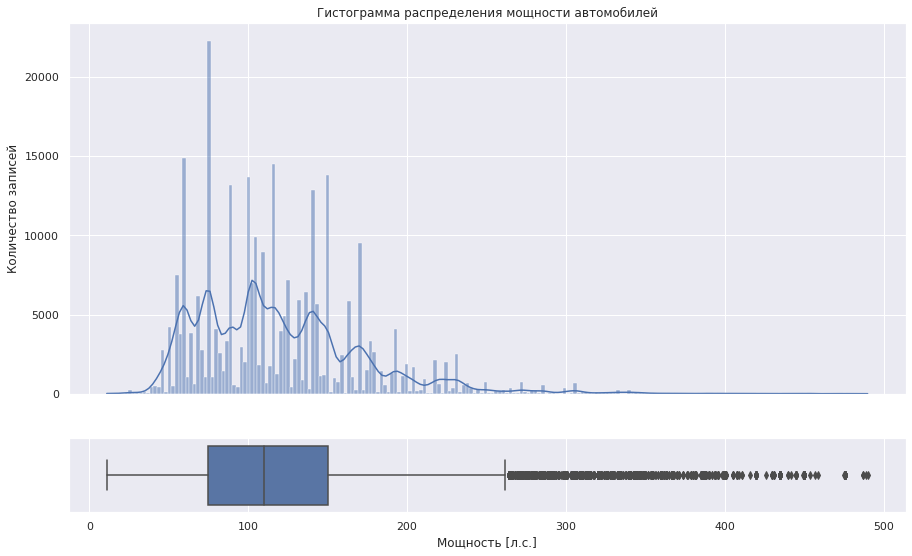

In [42]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = \
sns.histplot(data=df_study, x='power', 
             kde=True, ax=axs_hist)
box = sns.boxplot(data=df_study, x='power', orient='h', ax=axs_box)
box.set(xlabel='Мощность [л.с.]')
hist.set(title='Гистограмма распределения мощности автомобилей',
         ylabel='Количество записей');

#### model

In [43]:
df_study.model.describe().to_frame()

,model
count,280050
unique,248
top,golf
freq,24461


In [44]:
df_study.model.value_counts(normalize=True, dropna=False)

golf                  0.084200
other                 0.065547
3er                   0.059086
polo                  0.036732
NaN                   0.036002
                        ...   
i3                    0.000017
gl                    0.000014
range_rover_evoque    0.000007
rangerover            0.000007
serie_2               0.000003
Name: model, Length: 249, dtype: float64

Не вижу возможности заполнить пропуски исходя из имеющихся данных. Придётся их удалить.

In [45]:
df_study = df_study.dropna(axis=0, subset=['model'])
df_study.model.isna().mean()

0.0

#### kilometer

In [46]:
df_study.kilometer.isna().sum()

0

In [47]:
df_study.kilometer.describe()

count    280050.000000
mean     128999.607213
std       36006.343864
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

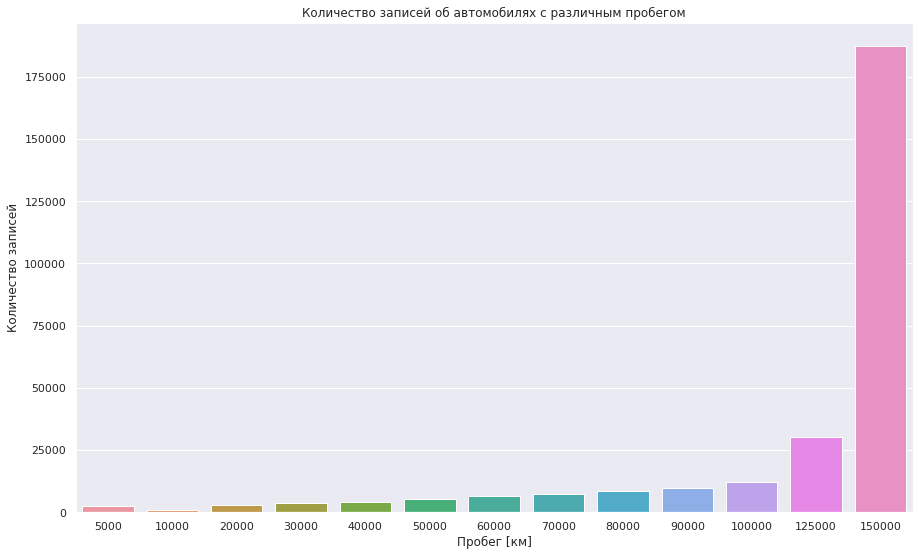

In [48]:
sns.countplot(data=df_study, x='kilometer')\
.set(title='Количество записей об автомобилях с различным пробегом',
    xlabel='Пробег [км]',
    ylabel='Количество записей');

В данной колонке не наблюдается ни пропусков данных, ни аномалий. Видна выраженная мода в районе 150 тысяч пробега.

#### fuel_type

In [49]:
df_study.fuel_type.value_counts(normalize=True, dropna=False)\
.sort_values(ascending=False).to_frame()

,fuel_type
petrol,0.636351
gasoline,0.299875
NaN,0.045399
lpg,0.015672
cng,0.001664
hybrid,0.000621
other,0.000225
electric,0.000193


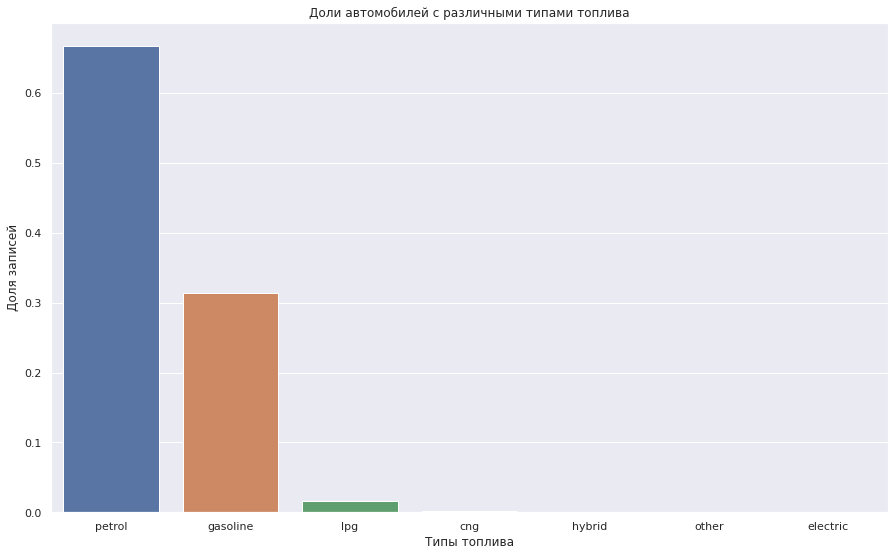

In [50]:
t = df_study.fuel_type.value_counts(normalize=True)\
.sort_values(ascending=False).to_frame()
ax = sns.barplot(data=t, y='fuel_type', x=t.index)

ax.set(xlabel='Типы топлива', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными типами топлива');

Как видно из графика, большинство автомобилей используют в качестве топлива petrol или gasoline. У нас имеется более пяти процентов пропусков данных. Заполним их исходя из информации о типе автомобиля.

In [51]:
fuel_dict = df_study.groupby('vehicle_type')['fuel_type'].agg(pd.Series.mode).to_dict()

In [52]:
fuel_dict

{'bus': 'gasoline',
 'convertible': 'petrol',
 'coupe': 'petrol',
 'other': 'gasoline',
 'sedan': 'petrol',
 'small': 'petrol',
 'suv': 'gasoline',
 'unknown': 'petrol',
 'wagon': 'gasoline'}

In [53]:
df_study.loc[
    df_study['fuel_type'].isna(), 
    'fuel_type'] = \
    df_study.loc[df['fuel_type'].isna(), 'vehicle_type'].map(fuel_dict)

In [54]:
df_study.fuel_type.value_counts(normalize=True, dropna=False)\
.sort_values(ascending=False).to_frame()

,fuel_type
petrol,0.671194
gasoline,0.310430
lpg,0.015672
cng,0.001664
hybrid,0.000621
other,0.000225
electric,0.000193


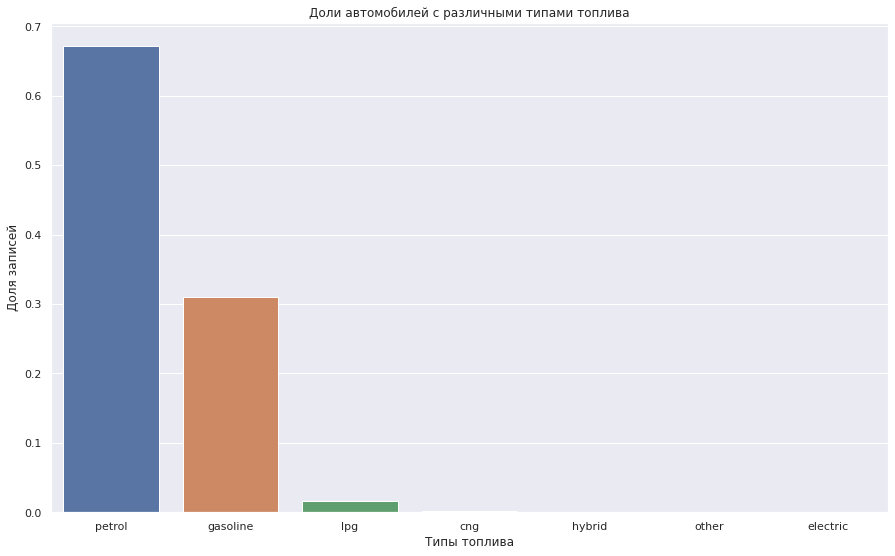

In [55]:
t = df_study.fuel_type.value_counts(normalize=True)\
.sort_values(ascending=False).to_frame()
ax = sns.barplot(data=t, y='fuel_type', x=t.index)

ax.set(xlabel='Типы топлива', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными типами топлива');

Пропуски данных обработаны, соотношение типов топлива изменилось незначительно.

Petrol - название бензина в британском английском, gasoline - американском английском. Эти два понятия обозначают одно и тоже, поэтому, стоит их объединить. Сольем обе колонки в одну - Petrol.

In [56]:
df_study['fuel_type'] = df_study['fuel_type'].replace('gasoline', 'petrol')

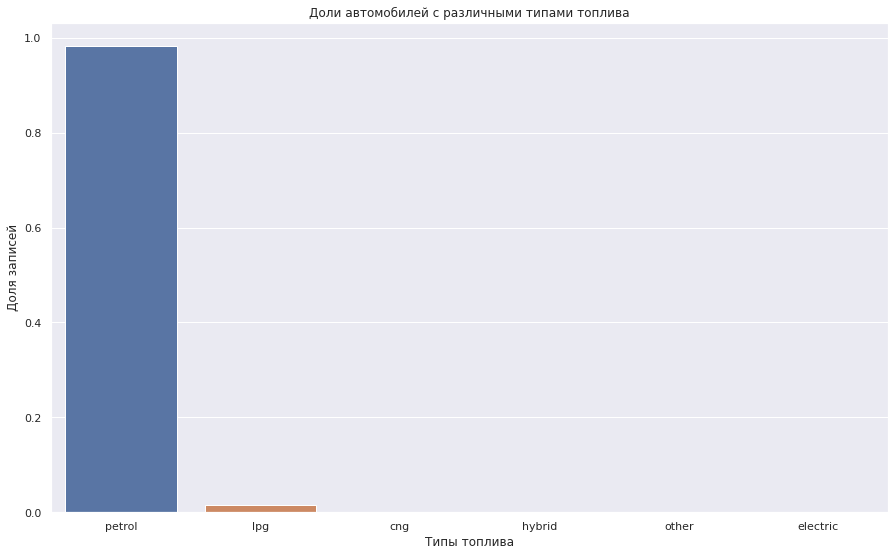

In [57]:
t = df_study.fuel_type.value_counts(normalize=True)\
.sort_values(ascending=False).to_frame()
ax = sns.barplot(data=t, y='fuel_type', x=t.index)

ax.set(xlabel='Типы топлива', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными типами топлива');

Хорошо, бензин стал одним. Переходим к маркам авто.

#### brand

In [58]:
df_study.brand.value_counts(normalize=True, dropna=False)

volkswagen       0.217811
opel             0.110923
bmw              0.108813
mercedes_benz    0.091798
audi             0.086595
ford             0.070909
renault          0.048109
peugeot          0.031641
fiat             0.025917
seat             0.020286
skoda            0.017183
mazda            0.016076
smart            0.015512
citroen          0.014494
nissan           0.013858
toyota           0.013833
hyundai          0.010584
mini             0.010123
volvo            0.009552
mitsubishi       0.008495
honda            0.008063
kia              0.007084
suzuki           0.006735
alfa_romeo       0.006624
chevrolet        0.004699
chrysler         0.003914
dacia            0.002810
subaru           0.002214
daihatsu         0.002142
jeep             0.001871
porsche          0.001843
saab             0.001621
land_rover       0.001503
jaguar           0.001414
daewoo           0.001375
lancia           0.001260
rover            0.001143
trabant          0.000686
lada        

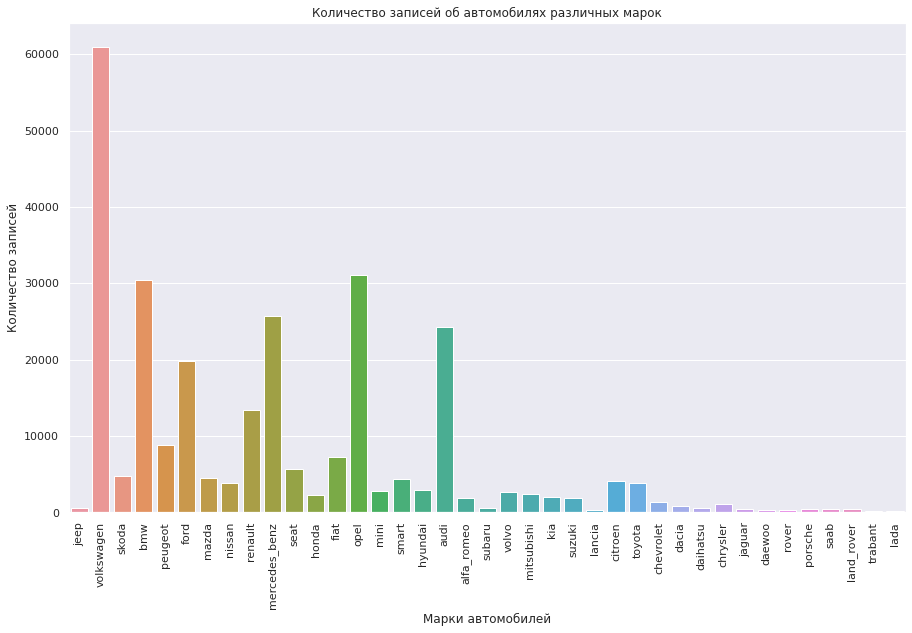

In [59]:
sns.countplot(data=df_study, x='brand')\
.set(xlabel='Марки автомобилей',
     ylabel='Количество записей',
     title='Количество записей об автомобилях различных марок')
plt.xticks(rotation=90);

Данные не нуждаются в корректировке.Всего в данных 39 марок авто. Большинство автомобилей произведено компанией Фольксваген, за ней следуют Опель, БМВ, Ауди и Мерседес. Думаю, что это будет одна из самых весомых колонок при обучении модели.

In [60]:
df_study

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,67112
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,2016,auto,150,159,150000,petrol,alfa_romeo,no,51371
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,96465
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no,87439


#### repaired

In [61]:
df_study.repaired.value_counts(normalize=True, dropna=False).to_frame()

,repaired
no,0.764938
NaN,0.137925
yes,0.097136


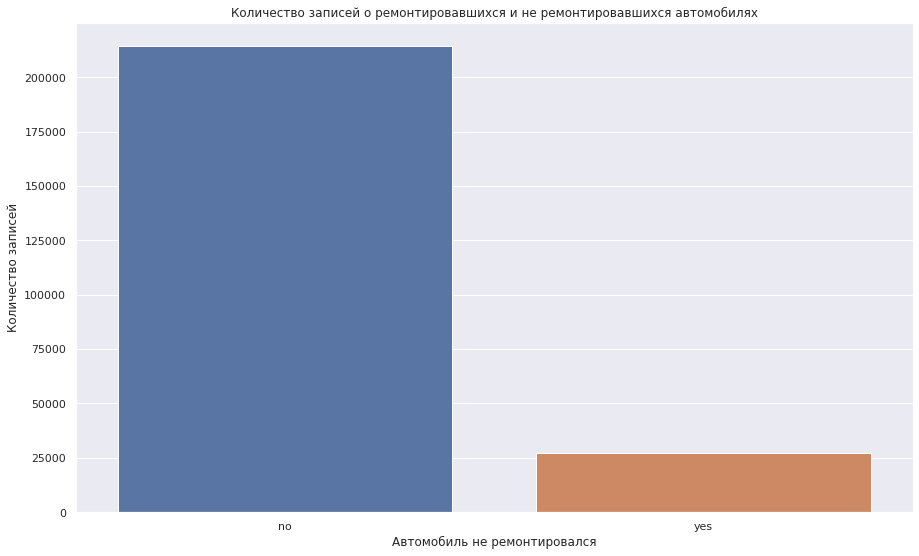

In [62]:
ax = sns.countplot(data=df_study, x='repaired')
ax.set(title='Количество записей о ремонтировавшихся и не ремонтировавшихся автомобилях',
     xlabel='Автомобиль не ремонтировался',
     ylabel='Количество записей');

Исходя из барплотов, видно что в имеющихся данных больше всего записей о неремонтированных автомобилях. Также имеется примерно 15 процентов данных с пропусками. Пропусков достаточно, так что просто отбросить данные мы не можем. Колонка очень важная для определения стоимости автомобиля, заполнение пропусков самым часто встречающися значением может привести к искажениям. Поэтому отметим все пропуски значением unknown.

In [63]:
df_study.repaired = df_study.repaired.fillna(value='unknown')

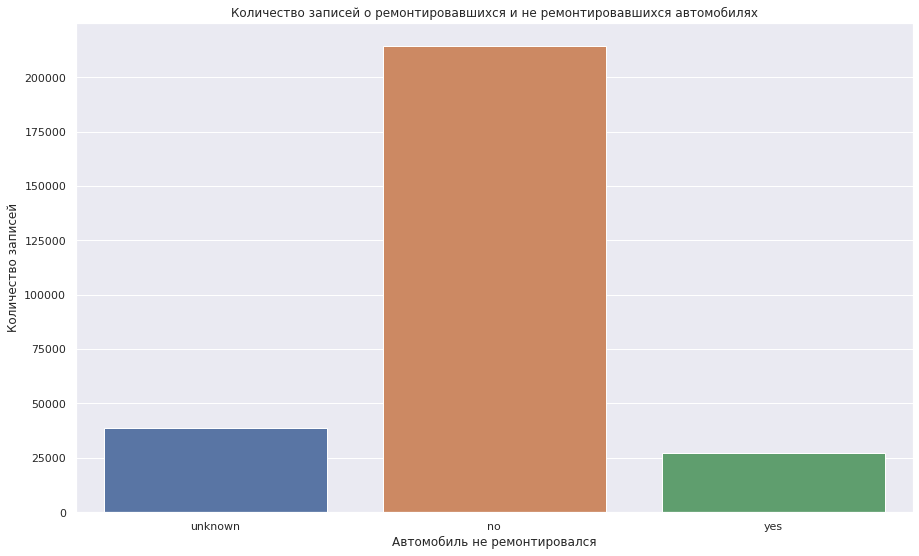

In [64]:
ax = sns.countplot(data=df_study, x='repaired')
ax.set(title='Количество записей о ремонтировавшихся и не ремонтировавшихся автомобилях',
     xlabel='Автомобиль не ремонтировался',
     ylabel='Количество записей');

Вывод.
В начале предобработки были отброшен ряд колонок, которые по мнению студента не оказывали существенного влияния на ценооразоование автомобиля.
Также, в процессе предобработки данных и исследовательского анализа были выявлены и устранены некоторые проблемы с данными. В ряде колонок были обнаружены и обработаны пропуски, аномалии и дубликаты. В каждом отдельном случае принималось решение по обработке, которое максимально бы сохранило данные, при этом не привело бы к их искажению. К сожалению, достаточно большое количество данных было удалено из-за неинформативности или невозможности их приведения к "нормальным" значениям.

## Подготовка данных

In [65]:
X = df_study[['vehicle_type', 'registration_year', 
                     'gearbox', 'power', 'model', 'kilometer', 
                     'fuel_type', 'brand', 'repaired']]
y = df_study['price']

<div class="alert alert-block alert-info">
<b>Комментарий студента </b> Перенес RandomState в начало проекта.
</div>

Разобьем на тренировочную и тестовую:

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_STATE, 
                                                    shuffle=True)

Еще выделим валидационную:

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=RANDOM_STATE, 
                                                  shuffle=True)

Можно переходить к обучению моделей.

## Обучение моделей

### CatBoostRegressor

In [68]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                'brand', 'repaired']

In [69]:
train_dataset = cb.Pool(X_train, y_train, cat_features=cat_features) 
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_features)

In [70]:
val_dataset = cb.Pool(X_val, y_val, cat_features=cat_features) 

In [71]:
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    task_type='CPU',
    verbose=False
)

In [72]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 8]}

In [73]:
%%time
grid_search_result  = cb_model.grid_search(grid, train_dataset)


bestTest = 1757.981292
bestIteration = 999

0:	loss: 1757.9812924	best: 1757.9812924 (0)	total: 40.3s	remaining: 3m 21s

bestTest = 1660.027479
bestIteration = 998

1:	loss: 1660.0274788	best: 1660.0274788 (1)	total: 1m 21s	remaining: 2m 42s

bestTest = 1616.295841
bestIteration = 999

2:	loss: 1616.2958409	best: 1616.2958409 (2)	total: 2m 51s	remaining: 2m 51s

bestTest = 1544.183136
bestIteration = 999

3:	loss: 1544.1831363	best: 1544.1831363 (3)	total: 4m 21s	remaining: 2m 10s

bestTest = 1511.79151
bestIteration = 999

4:	loss: 1511.7915096	best: 1511.7915096 (4)	total: 7m 46s	remaining: 1m 33s

bestTest = 1466.895342
bestIteration = 999

5:	loss: 1466.8953417	best: 1466.8953417 (5)	total: 11m 17s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 1469.640354
bestIteration = 994

Training on fold [1/3]

bestTest = 1450.100469
bestIteration = 999

Training on fold [2/3]

bestTest = 1474.775161
bestIteration = 998

CPU times: user 24min, sys: 27.1 s, tota

Модель CatBoost на кросс-валидации обеспечила метрику RMSE 1450 за 26 минут. Посмотрим, какое значение RMSE модель выдаст на валидационных данных.

In [74]:
cb_predict = cb_model.predict(val_dataset)

In [75]:
mean_squared_error(y_val, cb_predict, squared=False)

1461.865246144254

Заказчику важно время обучения и время предсказаний модели. Чтобы замерить это время обучим модель на валидационной выборке, а затем получим предсказания на ней же.

In [76]:
grid_search_result['params']

{'depth': 8, 'learning_rate': 0.1}

In [77]:
cb_model_val = cb.CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    task_type='CPU',
    depth=8,
    learning_rate=0.1,
    verbose=100
)

In [78]:
%%time
cb_model_val.fit(val_dataset)

0:	learn: 4046.4403279	total: 72.1ms	remaining: 1m 12s
100:	learn: 1562.6000914	total: 6.28s	remaining: 55.9s
200:	learn: 1478.2751945	total: 12.4s	remaining: 49.4s
300:	learn: 1421.7877727	total: 18.5s	remaining: 43s
400:	learn: 1381.4863828	total: 24.9s	remaining: 37.2s
500:	learn: 1349.7656586	total: 31.3s	remaining: 31.1s
600:	learn: 1322.6643057	total: 37.9s	remaining: 25.2s
700:	learn: 1298.1714013	total: 44.5s	remaining: 19s
800:	learn: 1278.8882348	total: 51s	remaining: 12.7s
900:	learn: 1259.5961796	total: 57.3s	remaining: 6.29s
999:	learn: 1245.8117967	total: 1m 3s	remaining: 0us
CPU times: user 1min 3s, sys: 700 ms, total: 1min 4s
Wall time: 1min 4s


In [79]:
%%time
cb_model_val.predict(val_dataset)

CPU times: user 529 ms, sys: 0 ns, total: 529 ms
Wall time: 537 ms


array([ 3548.09350293, 11353.50681846,  3716.69066804, ...,
       10946.54137295,   827.73567722,  7228.3747802 ])

Запишем данные в таблицу

In [80]:
results = pd.DataFrame({
    'model': ['CatBoost'],
    'fittime': ['1 min 10 s'],
    'predtime': ['535 ms'],
    'rmse': [1461]
})

In [81]:
results

,model,fittime,predtime,rmse
0,CatBoost,1 min 10 s,535 ms,1461


### Нейронная сеть

Опыта обучения нейронок у меня нет, но в теории о них уже начали говорить. Попробуем.

In [82]:
nn_dataset = pd.concat([X_test, y_test], axis=1)

In [83]:
splits = RandomSplitter(valid_pct=0.2)(range_of(nn_dataset))

In [84]:
to = TabularPandas(nn_dataset, procs=[Categorify, Normalize],
                   cat_names = cat_features,
                   cont_names = ['power', 'kilometer', 'registration_year'],
                   y_names='price',
                   splits=splits)

In [85]:
dls = to.dataloaders(bs=64)

In [86]:
learner = tabular_learner(dls, metrics=rmse)

In [87]:
%%time
learner.fit(20)

epoch,train_loss,valid_loss,_rmse,time
0,40194788.000000,39659116.000000,6297.547852,00:23
1,36914868.000000,36143480.000000,6011.945801,00:24
2,32083722.000000,31121106.000000,5578.629395,00:24
3,26001076.000000,25738670.000000,5073.329102,00:24
4,20235816.000000,19161148.000000,4377.345215,00:24
5,13903857.000000,13576398.000000,3684.616455,00:23
6,9461825.000000,8936005.000000,2989.315186,00:24
7,6127356.500000,5519735.500000,2349.411865,00:23
8,3633187.750000,3421724.500000,1849.790161,00:24
9,3147728.750000,2784624.500000,1668.719238,00:23


CPU times: user 7min 47s, sys: 5.49 s, total: 7min 52s
Wall time: 8min 5s


In [88]:
val_df = X_val.copy()
dl = learner.dls.test_dl(val_df)

In [89]:
%%time
y_pred_nn, _ = learner.get_preds(dl=dl)

CPU times: user 8.3 s, sys: 105 ms, total: 8.4 s
Wall time: 8.68 s


In [90]:
mean_squared_error(y_val, y_pred_nn, squared=False)

1641.685095330636

Для нейронной сети обучение заняло 12 минут 16 секунд, предсказание получено за 15 секунд, метрика RMSE равна 1604. Добавим данные в таблицу:

In [91]:
results = results.append({
    'model': 'Neural Network',
    'fittime': '12 min 16 s',
    'predtime': '15 s',
    'rmse': 1604
}, ignore_index=True)

In [92]:
results

,model,fittime,predtime,rmse
0,CatBoost,1 min 10 s,535 ms,1461
1,Neural Network,12 min 16 s,15 s,1604


### LightGBM

In [93]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_val_lgbm = X_val.copy()

In [94]:
for feature in cat_features:
    X_train_lgbm[feature] = pd.Series(X_train_lgbm[feature], dtype='category')
    X_test_lgbm[feature] = pd.Series(X_test_lgbm[feature], dtype='category')
    X_val_lgbm[feature] = pd.Series(X_val_lgbm[feature], dtype='category')

In [95]:
def objective(trial):
  X_train_l, X_val_l, y_train_l, y_val_l = train_test_split(X_train_lgbm, y_train, test_size = 0.2)
  dtrain = lgbm.Dataset(X_train_l, label=y_train_l)

  param = {
      'metric': 'root_mean_squared_error',
      'random_state': RANDOM_STATE,
      'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
      'max_depth': trial.suggest_int('max_depth', 2, 8),
  }

  gbm = lgbm.train(param, dtrain)
  y_pred_l = gbm.predict(X_val_l)
  rmse = mean_squared_error(y_val_l, y_pred_l, squared=False)
  return rmse

In [96]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-06-12 15:46:33,626] A new study created in memory with name: no-name-8338b517-f8fd-4d62-a99f-b72d37b7b54c


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.282965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-06-12 15:46:35,500] Trial 0 finished with value: 1603.8207264130758 and parameters: {'learning_rate': 0.06703946803598693, 'max_depth': 4}. Best is trial 0 with value: 1603.8207264130758.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4702.645207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:46:38,300] Trial 1 finished with value: 1516.3326022961946 and parameters: {'learning_rate': 0.09193836091072496, 'max_depth': 6}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4706.163399


[I 2024-06-12 15:46:39,896] Trial 2 finished with value: 1714.3450089465448 and parameters: {'learning_rate': 0.07018082597603872, 'max_depth': 3}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4700.949925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-06-12 15:46:42,298] Trial 3 finished with value: 1531.545479579306 and parameters: {'learning_rate': 0.08947930337207012, 'max_depth': 5}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4712.949304


[I 2024-06-12 15:46:43,999] Trial 4 finished with value: 1689.737706492882 and parameters: {'learning_rate': 0.06861704588233306, 'max_depth': 3}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4717.070586


[I 2024-06-12 15:46:45,403] Trial 5 finished with value: 1670.0413568977692 and parameters: {'learning_rate': 0.06708726808374416, 'max_depth': 3}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4705.405705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-06-12 15:46:47,807] Trial 6 finished with value: 1532.9682910067525 and parameters: {'learning_rate': 0.09007104161612366, 'max_depth': 5}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4712.027520


[I 2024-06-12 15:46:50,799] Trial 7 finished with value: 1581.4360700416905 and parameters: {'learning_rate': 0.039740522485529076, 'max_depth': 6}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.934247


[I 2024-06-12 15:46:53,599] Trial 8 finished with value: 1551.2665885855897 and parameters: {'learning_rate': 0.056840964329920945, 'max_depth': 7}. Best is trial 1 with value: 1516.3326022961946.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4718.974028


[I 2024-06-12 15:46:56,210] Trial 9 finished with value: 1515.8503329178438 and parameters: {'learning_rate': 0.07834642416934393, 'max_depth': 6}. Best is trial 9 with value: 1515.8503329178438.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4698.653423


[I 2024-06-12 15:46:59,218] Trial 10 finished with value: 1595.3221909303272 and parameters: {'learning_rate': 0.033908394526585554, 'max_depth': 8}. Best is trial 9 with value: 1515.8503329178438.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4699.650647


[I 2024-06-12 15:47:02,006] Trial 11 finished with value: 1525.7190273889362 and parameters: {'learning_rate': 0.09904577748026616, 'max_depth': 7}. Best is trial 9 with value: 1515.8503329178438.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4697.311106


[I 2024-06-12 15:47:04,602] Trial 12 finished with value: 1519.8836225973969 and parameters: {'learning_rate': 0.08213453528505531, 'max_depth': 6}. Best is trial 9 with value: 1515.8503329178438.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.224222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:47:06,998] Trial 13 finished with value: 1520.4390585077879 and parameters: {'learning_rate': 0.08030672058058883, 'max_depth': 6}. Best is trial 9 with value: 1515.8503329178438.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4712.176218


[I 2024-06-12 15:47:09,691] Trial 14 finished with value: 1502.4880323335926 and parameters: {'learning_rate': 0.09841445903497904, 'max_depth': 8}. Best is trial 14 with value: 1502.4880323335926.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4701.428559


[I 2024-06-12 15:47:12,499] Trial 15 finished with value: 1539.5347264661798 and parameters: {'learning_rate': 0.053648829845182495, 'max_depth': 8}. Best is trial 14 with value: 1502.4880323335926.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4704.318527


[I 2024-06-12 15:47:15,104] Trial 16 finished with value: 1526.3231412531486 and parameters: {'learning_rate': 0.07809264314615605, 'max_depth': 7}. Best is trial 14 with value: 1502.4880323335926.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.545706


[I 2024-06-12 15:47:17,815] Trial 17 finished with value: 1524.4805089370143 and parameters: {'learning_rate': 0.09719214170518006, 'max_depth': 8}. Best is trial 14 with value: 1502.4880323335926.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.826955


[I 2024-06-12 15:47:19,115] Trial 18 finished with value: 1908.1428909181163 and parameters: {'learning_rate': 0.05611640956555404, 'max_depth': 2}. Best is trial 14 with value: 1502.4880323335926.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4706.524853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2024-06-12 15:47:21,801] Trial 19 finished with value: 1544.2177858090922 and parameters: {'learning_rate': 0.07670262703683409, 'max_depth': 5}. Best is trial 14 with value: 1502.4880323335926.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4715.037110


[I 2024-06-12 15:47:24,422] Trial 20 finished with value: 1496.192564317456 and parameters: {'learning_rate': 0.08609220873218602, 'max_depth': 7}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4704.013356


[I 2024-06-12 15:47:26,915] Trial 21 finished with value: 1506.2114716092096 and parameters: {'learning_rate': 0.08358414818925075, 'max_depth': 7}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4707.166963


[I 2024-06-12 15:47:29,694] Trial 22 finished with value: 1506.5678357047445 and parameters: {'learning_rate': 0.0864761926130282, 'max_depth': 7}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.815873


[I 2024-06-12 15:47:32,304] Trial 23 finished with value: 1509.4433531256398 and parameters: {'learning_rate': 0.09520343448312983, 'max_depth': 8}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4705.555023


[I 2024-06-12 15:47:35,002] Trial 24 finished with value: 1515.605717599034 and parameters: {'learning_rate': 0.08590310758913074, 'max_depth': 7}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4715.170039


[I 2024-06-12 15:47:37,809] Trial 25 finished with value: 1507.190007772226 and parameters: {'learning_rate': 0.0741669796357177, 'max_depth': 8}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.724253


[I 2024-06-12 15:47:40,411] Trial 26 finished with value: 1496.8831986701243 and parameters: {'learning_rate': 0.09440357806880503, 'max_depth': 7}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.500987


[I 2024-06-12 15:47:42,815] Trial 27 finished with value: 1513.1780932136203 and parameters: {'learning_rate': 0.09544837929333291, 'max_depth': 8}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.377452


[I 2024-06-12 15:47:45,517] Trial 28 finished with value: 1504.759372369886 and parameters: {'learning_rate': 0.09900750709499444, 'max_depth': 7}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4700.507354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-06-12 15:47:47,505] Trial 29 finished with value: 1559.9167394792485 and parameters: {'learning_rate': 0.09266867627548296, 'max_depth': 4}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4701.261052


[I 2024-06-12 15:47:50,209] Trial 30 finished with value: 1500.508605305242 and parameters: {'learning_rate': 0.08809220450220061, 'max_depth': 8}. Best is trial 20 with value: 1496.192564317456.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4698.146319


[I 2024-06-12 15:47:52,717] Trial 31 finished with value: 1493.5373562506948 and parameters: {'learning_rate': 0.08800275802512635, 'max_depth': 8}. Best is trial 31 with value: 1493.5373562506948.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4704.293908


[I 2024-06-12 15:47:55,322] Trial 32 finished with value: 1510.8742195754144 and parameters: {'learning_rate': 0.08876606991316062, 'max_depth': 8}. Best is trial 31 with value: 1493.5373562506948.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4712.838205


[I 2024-06-12 15:47:58,101] Trial 33 finished with value: 1525.8679076801247 and parameters: {'learning_rate': 0.07239265272905981, 'max_depth': 7}. Best is trial 31 with value: 1493.5373562506948.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4695.558036


[I 2024-06-12 15:48:00,712] Trial 34 finished with value: 1528.8748871599328 and parameters: {'learning_rate': 0.06251108192107124, 'max_depth': 6}. Best is trial 31 with value: 1493.5373562506948.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4698.401813


[I 2024-06-12 15:48:03,598] Trial 35 finished with value: 1535.0465122021442 and parameters: {'learning_rate': 0.09312497762914905, 'max_depth': 8}. Best is trial 31 with value: 1493.5373562506948.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4712.266597


[I 2024-06-12 15:48:06,310] Trial 36 finished with value: 1490.2703914480935 and parameters: {'learning_rate': 0.08587718531149253, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.869777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-06-12 15:48:08,716] Trial 37 finished with value: 1530.5934742189686 and parameters: {'learning_rate': 0.08519146493820395, 'max_depth': 5}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.555246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:48:11,304] Trial 38 finished with value: 1503.6459401912875 and parameters: {'learning_rate': 0.09096709820763917, 'max_depth': 6}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.378464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:48:13,390] Trial 39 finished with value: 1646.3231719551468 and parameters: {'learning_rate': 0.045695461525751234, 'max_depth': 4}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.563811


[I 2024-06-12 15:48:16,041] Trial 40 finished with value: 1530.6774069923354 and parameters: {'learning_rate': 0.06365593345457483, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4703.613474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:48:18,924] Trial 41 finished with value: 1539.0504248295508 and parameters: {'learning_rate': 0.08753529616556589, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4701.008613


[I 2024-06-12 15:48:21,804] Trial 42 finished with value: 1531.7075317841911 and parameters: {'learning_rate': 0.08226399193649062, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4705.329114


[I 2024-06-12 15:48:24,415] Trial 43 finished with value: 1510.2690755921542 and parameters: {'learning_rate': 0.09092821571753262, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4707.473599


[I 2024-06-12 15:48:27,502] Trial 44 finished with value: 1501.579599374747 and parameters: {'learning_rate': 0.09425914156503117, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4702.105220


[I 2024-06-12 15:48:30,113] Trial 45 finished with value: 1535.115784953844 and parameters: {'learning_rate': 0.07989851796760729, 'max_depth': 6}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.721582


[I 2024-06-12 15:48:33,207] Trial 46 finished with value: 1516.8735184959896 and parameters: {'learning_rate': 0.07431233386915997, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4704.696816


[I 2024-06-12 15:48:35,895] Trial 47 finished with value: 1496.5238787948988 and parameters: {'learning_rate': 0.08950044951356355, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4703.014611


[I 2024-06-12 15:48:38,513] Trial 48 finished with value: 1515.45716852272 and parameters: {'learning_rate': 0.08275280385595563, 'max_depth': 6}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4700.163678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-06-12 15:48:40,908] Trial 49 finished with value: 1546.0039539742277 and parameters: {'learning_rate': 0.09050145714505425, 'max_depth': 5}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4704.208815


[I 2024-06-12 15:48:43,993] Trial 50 finished with value: 1524.6397003751795 and parameters: {'learning_rate': 0.06743141572269362, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.367465


[I 2024-06-12 15:48:46,410] Trial 51 finished with value: 1498.1463130884738 and parameters: {'learning_rate': 0.08854616086230914, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4703.049935


[I 2024-06-12 15:48:49,217] Trial 52 finished with value: 1519.4760848021135 and parameters: {'learning_rate': 0.09469654109552265, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.761990


[I 2024-06-12 15:48:51,814] Trial 53 finished with value: 1517.9880616462676 and parameters: {'learning_rate': 0.08455435717145249, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4701.008104


[I 2024-06-12 15:48:54,613] Trial 54 finished with value: 1502.46213318948 and parameters: {'learning_rate': 0.08006447802114307, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4704.048178


[I 2024-06-12 15:48:57,108] Trial 55 finished with value: 1518.0864089380332 and parameters: {'learning_rate': 0.09668534017016002, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4712.859260


[I 2024-06-12 15:48:58,399] Trial 56 finished with value: 1786.2308037060957 and parameters: {'learning_rate': 0.08861834196151643, 'max_depth': 2}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4702.564487


[I 2024-06-12 15:49:00,906] Trial 57 finished with value: 1523.7669474988736 and parameters: {'learning_rate': 0.09211108840823003, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4703.830715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:49:03,393] Trial 58 finished with value: 1506.0516902154025 and parameters: {'learning_rate': 0.09957913930314281, 'max_depth': 6}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4711.379461


[I 2024-06-12 15:49:05,918] Trial 59 finished with value: 1512.0753611997654 and parameters: {'learning_rate': 0.07652161130978752, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4703.928828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:49:07,219] Trial 60 finished with value: 1674.1559748052737 and parameters: {'learning_rate': 0.08520936803816241, 'max_depth': 3}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4701.353998


[I 2024-06-12 15:49:09,797] Trial 61 finished with value: 1519.7949151256005 and parameters: {'learning_rate': 0.08689418428854212, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.055278


[I 2024-06-12 15:49:12,597] Trial 62 finished with value: 1509.7681091796994 and parameters: {'learning_rate': 0.08812714353454011, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4704.755930


[I 2024-06-12 15:49:15,308] Trial 63 finished with value: 1529.7952339958795 and parameters: {'learning_rate': 0.08106391885463182, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4705.926324


[I 2024-06-12 15:49:18,112] Trial 64 finished with value: 1507.8106043780972 and parameters: {'learning_rate': 0.0893289167933698, 'max_depth': 8}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4697.998842


[I 2024-06-12 15:49:20,719] Trial 65 finished with value: 1523.8194687819716 and parameters: {'learning_rate': 0.09275557810037255, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4707.963016


[I 2024-06-12 15:49:23,529] Trial 66 finished with value: 1511.3085700183399 and parameters: {'learning_rate': 0.08401824335820558, 'max_depth': 7}. Best is trial 36 with value: 1490.2703914480935.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4718.303979


[I 2024-06-12 15:49:26,210] Trial 67 finished with value: 1482.1434360093149 and parameters: {'learning_rate': 0.09565084279711816, 'max_depth': 8}. Best is trial 67 with value: 1482.1434360093149.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.215197


[I 2024-06-12 15:49:29,010] Trial 68 finished with value: 1488.2656939124054 and parameters: {'learning_rate': 0.0968712450536764, 'max_depth': 8}. Best is trial 67 with value: 1482.1434360093149.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4705.794239


[I 2024-06-12 15:49:31,891] Trial 69 finished with value: 1495.6695153672802 and parameters: {'learning_rate': 0.09654356282032008, 'max_depth': 8}. Best is trial 67 with value: 1482.1434360093149.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.345441


[I 2024-06-12 15:49:34,416] Trial 70 finished with value: 1491.997072205173 and parameters: {'learning_rate': 0.09978370152944978, 'max_depth': 8}. Best is trial 67 with value: 1482.1434360093149.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4713.024926


[I 2024-06-12 15:49:37,408] Trial 71 finished with value: 1503.9152206878196 and parameters: {'learning_rate': 0.09723265277877066, 'max_depth': 8}. Best is trial 67 with value: 1482.1434360093149.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4713.170743


[I 2024-06-12 15:49:40,215] Trial 72 finished with value: 1506.9500235093233 and parameters: {'learning_rate': 0.09719104829283771, 'max_depth': 8}. Best is trial 67 with value: 1482.1434360093149.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4706.283565


[I 2024-06-12 15:49:42,908] Trial 73 finished with value: 1494.2074560072317 and parameters: {'learning_rate': 0.09646007560670945, 'max_depth': 8}. Best is trial 67 with value: 1482.1434360093149.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4724.160407


[I 2024-06-12 15:49:45,694] Trial 74 finished with value: 1475.4832920825552 and parameters: {'learning_rate': 0.09875914764105503, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4701.788953


[I 2024-06-12 15:49:48,316] Trial 75 finished with value: 1507.9276985860326 and parameters: {'learning_rate': 0.09981328418156213, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4699.685588


[I 2024-06-12 15:49:51,094] Trial 76 finished with value: 1497.4166494904819 and parameters: {'learning_rate': 0.09606452880238672, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4701.093622


[I 2024-06-12 15:49:53,806] Trial 77 finished with value: 1500.588095867607 and parameters: {'learning_rate': 0.09797102668719515, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.933375


[I 2024-06-12 15:49:56,514] Trial 78 finished with value: 1489.744840921249 and parameters: {'learning_rate': 0.09460330836093471, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4702.396422


[I 2024-06-12 15:49:59,411] Trial 79 finished with value: 1501.130456109609 and parameters: {'learning_rate': 0.09478142792839618, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4709.253597


[I 2024-06-12 15:50:02,299] Trial 80 finished with value: 1505.2592912053651 and parameters: {'learning_rate': 0.09998831477665364, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4711.826244


[I 2024-06-12 15:50:05,020] Trial 81 finished with value: 1492.9819587013508 and parameters: {'learning_rate': 0.0935559830031631, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.419667


[I 2024-06-12 15:50:07,916] Trial 82 finished with value: 1510.5053212750563 and parameters: {'learning_rate': 0.09328242919892034, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4703.415957


[I 2024-06-12 15:50:10,417] Trial 83 finished with value: 1510.2447639100938 and parameters: {'learning_rate': 0.09177101290265406, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.832549


[I 2024-06-12 15:50:13,801] Trial 84 finished with value: 1620.6943708465171 and parameters: {'learning_rate': 0.03192108592482913, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4706.198696


[I 2024-06-12 15:50:16,418] Trial 85 finished with value: 1506.5909013160613 and parameters: {'learning_rate': 0.09816811437003321, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.327705


[I 2024-06-12 15:50:18,810] Trial 86 finished with value: 1503.957510461673 and parameters: {'learning_rate': 0.0933833000669747, 'max_depth': 7}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4706.349262


[I 2024-06-12 15:50:21,613] Trial 87 finished with value: 1503.7173464133505 and parameters: {'learning_rate': 0.09566736780452324, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4714.101280


[I 2024-06-12 15:50:24,206] Trial 88 finished with value: 1500.0544821357348 and parameters: {'learning_rate': 0.09082037276473767, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4702.975325


[I 2024-06-12 15:50:26,824] Trial 89 finished with value: 1518.8367523538705 and parameters: {'learning_rate': 0.09859897795812204, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4703.659372


[I 2024-06-12 15:50:29,595] Trial 90 finished with value: 1517.3981167081415 and parameters: {'learning_rate': 0.09447283504809997, 'max_depth': 7}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4711.477972


[I 2024-06-12 15:50:32,403] Trial 91 finished with value: 1484.970646704448 and parameters: {'learning_rate': 0.09631566452418093, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4715.843610


[I 2024-06-12 15:50:35,304] Trial 92 finished with value: 1523.8302060098836 and parameters: {'learning_rate': 0.049735899912134104, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4707.746696


[I 2024-06-12 15:50:38,003] Trial 93 finished with value: 1502.7102730212005 and parameters: {'learning_rate': 0.09570742020195784, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4705.789267


[I 2024-06-12 15:50:40,898] Trial 94 finished with value: 1543.7027229021667 and parameters: {'learning_rate': 0.060281366530464814, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.885895


[I 2024-06-12 15:50:43,614] Trial 95 finished with value: 1480.7391712124502 and parameters: {'learning_rate': 0.09759102093852312, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4698.276717


[I 2024-06-12 15:50:46,303] Trial 96 finished with value: 1506.5905068636278 and parameters: {'learning_rate': 0.09850206313106832, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4710.958985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-12 15:50:49,298] Trial 97 finished with value: 1511.2917375037625 and parameters: {'learning_rate': 0.09185131742952617, 'max_depth': 7}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4698.633058


[I 2024-06-12 15:50:51,906] Trial 98 finished with value: 1511.869921551666 and parameters: {'learning_rate': 0.09301152155906545, 'max_depth': 8}. Best is trial 74 with value: 1475.4832920825552.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 143385, number of used features: 9
[LightGBM] [Info] Start training from score 4698.249343


[I 2024-06-12 15:50:54,602] Trial 99 finished with value: 1510.41868507345 and parameters: {'learning_rate': 0.09009253847200968, 'max_depth': 7}. Best is trial 74 with value: 1475.4832920825552.


CPU times: user 4min 16s, sys: 2.33 s, total: 4min 18s
Wall time: 4min 20s


Модель на основе LightGDM на кросс-валидации обеспечила метрику 1516. Подбор гипер-параметров занял 9 минут 21 секунду.

In [97]:
model_lgbm = lgbm.LGBMRegressor(random_state=RANDOM_STATE,
                                metric='root_mean_squared_error',
                                learning_rate=0.0956621333321235,
                                max_depth=7
                                )

In [98]:
%%time
model_lgbm.fit(X_train_lgbm, y_train)

CPU times: user 2.55 s, sys: 31.3 ms, total: 2.58 s
Wall time: 2.57 s


LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [99]:
y_pred_lgbm = model_lgbm.predict(X_val_lgbm)

In [100]:
mean_squared_error(y_val, y_pred_lgbm, squared=False)

1512.91597600678

На валидационной выборке LightGBM обеспечивает RMSE 1512. Для сравнения с другими моделями измерим время обучения и предсказания.

In [101]:
%%time
model_lgbm.fit(X_val_lgbm, y_val)

CPU times: user 1.07 s, sys: 7.54 ms, total: 1.08 s
Wall time: 1.09 s


LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [102]:
%%time
model_lgbm.predict(X_val_lgbm)

CPU times: user 504 ms, sys: 0 ns, total: 504 ms
Wall time: 504 ms


array([ 3500.2205484 , 12130.82406207,  3631.16207189, ...,
       11038.10307074,   579.80205314,  6842.59517764])

Модель LightGBM обучилась за 2.59 секунд, выдала предсказания за 566 миллисекунду.

In [103]:
results = results.append({
    'model': 'LightGBM',
    'fittime': '2.87 s',
    'predtime': '510 ms',
    'rmse': 1522
}, ignore_index=True)
results

,model,fittime,predtime,rmse
0,CatBoost,1 min 10 s,535 ms,1461
1,Neural Network,12 min 16 s,15 s,1604
2,LightGBM,2.87 s,510 ms,1522


Посчитаем для LightGBM значение метрики на тестовой выборке.

In [104]:
X_train_fin = pd.concat([X_train, X_val])
y_train_fin = pd.concat([y_train, y_val])

In [105]:
for feature in cat_features:
    X_train_fin[feature] = pd.Series(X_train_fin[feature], dtype='category')

In [106]:
model_lgbm.fit(X_train_fin, y_train_fin)

LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [107]:
%%time
y_pred_lgbm = model_lgbm.predict(X_test_lgbm)

CPU times: user 597 ms, sys: 3.8 ms, total: 601 ms
Wall time: 601 ms


In [108]:
mean_squared_error(y_test, y_pred_lgbm, squared=False)

1505.6972508689637

На тестовой выборке значение RMSE для модели LightGBM составило 1520. Предсказания были получены за 692 миллисекунд.

## Анализ моделей

В рамках работы над проектом были обучены 3 модели. Заказчика интересует время обучения, время предсказаний и значения метрики RMSE.
Посмотрим на полученную таблицу с результатами:

In [109]:
results

,model,fittime,predtime,rmse
0,CatBoost,1 min 10 s,535 ms,1461
1,Neural Network,12 min 16 s,15 s,1604
2,LightGBM,2.87 s,510 ms,1522


Из таблицы видно, что самая точная модель - CatBoostRegressor. Следом за ней идет LightGBM и замыкает тройку - нейронная сеть.
Несмотря на то, что CatBoost самая точная, стоит обратить внимание на LightGBM. Её метрика RMSE несущественно ниже, но быстродействие явно лучше в разы.

## Общий вывод по проекту

Работа над проектом включала несколько этапов:

    Загрузка данных и библиотек;
    - Первичный осмотр данных;
    - Предобработка данных;
    - Исследовательский анализ данных;
    - Подготовка данных для обучения моделей;
    - Обучение моделей;
    - Сравнение показателей точности и быстродействия моделей.
    
В рамках первичного осмотра было проведено короткое ознакомление с данными, были выявлены некоторые неточности и ошибки загрузки. В данном проекте, предобработку и ИАД было решено совместить, поскольку от заказачика не было запроса на выявление каких-либо закономерностей в представленной информации. Этап предобработки и ИАД помог подготовить данные для непосредственной подготовки к обучению. Были отсеяны некоторые неинвормативные признаки, удалены дубликаты, обработаны странные значения и аномалии. В качестве исслудемых моделей были выбраны CatBoost, Neural Network и обязательная по заданию LightGBM.
В результате проведенной работы установлено, что наиболее точная модель - это CatBoost. При этом LightGBM немного уступает ей в точности но существенно превосходит в быстродействии.
ПОэтому, исходя из требований заказчика (точность (RMSE), время обучения, время предсказания) стоит порекомендовать ему строить свое приложение для рыночной оценки авто на основе модели LightGBM.